#  Wildfire Fire Detection from Satellite Imagery  (UNET)

## Import libraries

In [1]:
#Import Libraries
import os
import sys
import time
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Add the path to the functions directory
sys.path.append('../functions')  # Add the path to the functions directory

## A. Load Dataset

### A Load tiles from ../dataset/tiles

In [4]:
# import user defined function for loading tiles from datasets/tiles using functions/load_dataset.py
from load_dataset import load_images_from_directory

In [5]:
# specify path and call function 
directory = "../dataset/tiles"
tiles = load_images_from_directory(directory)

- ### Visualize tile after loading 

Number of images loaded: 99
Shape of sample image: (512, 512, 3)


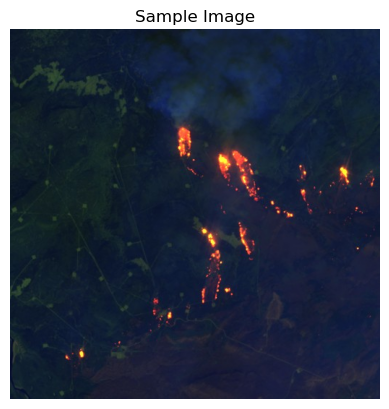

In [6]:
# confirm if tiles [] holds images, print length and plot 

# Confirm if tiles[] holds images
if len(tiles) > 0:
    # Display the number of images loaded
    print(f"Number of images loaded: {len(tiles)}")

    # Display a sample image
    sample_tile = tiles[1]

    print(f"Shape of sample image: {sample_tile.shape}")

    # Plot the sample image
    plt.imshow(cv2.cvtColor(sample_tile, cv2.COLOR_BGR2RGB))
    plt.title("Sample Image")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded from the directory.")


- ### Print tile image matrix 

In [7]:
## View Image matrix to see values
print(tiles[1])

[[[40 22 11]
  [40 22 11]
  [39 21 10]
  ...
  [66 32 16]
  [66 32 16]
  [66 32 16]]

 [[40 22 11]
  [40 22 11]
  [40 22 11]
  ...
  [67 33 17]
  [67 33 17]
  [67 33 17]]

 [[41 23 12]
  [41 23 12]
  [41 23 12]
  ...
  [68 35 19]
  [68 35 19]
  [67 34 18]]

 ...

 [[46 22 10]
  [47 23 11]
  [48 24 12]
  ...
  [62 34 27]
  [62 32 27]
  [63 33 28]]

 [[49 22 12]
  [50 23 13]
  [50 25 15]
  ...
  [63 35 28]
  [63 33 28]
  [64 34 29]]

 [[47 22 12]
  [48 23 13]
  [49 24 14]
  ...
  [64 36 29]
  [64 34 29]
  [65 35 30]]]


- ### Print tile data type

In [8]:
tiles[1].dtype

dtype('uint8')

- ### Normalize Tiles to values [0,1]

In [9]:
# import user defined function for normalizing tiles from functions/tile_normalize
from tile_normalize import normalize_tiles

In [10]:
# call function to normalize
normalized_tiles = normalize_tiles(tiles)

- ### Print normalized tile data type

In [11]:
normalized_tiles[0].dtype

dtype('float64')

- ### Visualize Normalized Tiles

Number of images loaded: 99
Shape of sample image: (512, 512, 3)


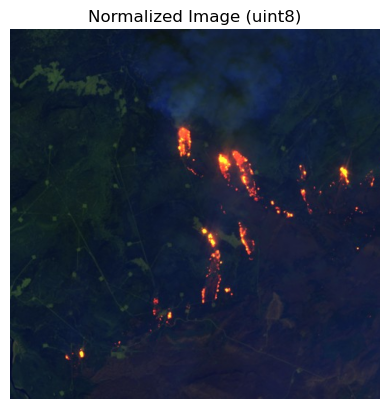

In [12]:
# confirm if tiles [] holds images, print length and plot 

# Confirm if tiles[] holds images
if len(normalized_tiles) > 0:
    # Display the number of images loaded
    print(f"Number of images loaded: {len(normalized_tiles)}")

    # Display a sample image
    sample_tile = normalized_tiles[1]

    print(f"Shape of sample image: {sample_tile.shape}")

    uint8_image = (sample_tile * 255).astype(np.uint8)
    # Plot the uint8 image
    plt.imshow(cv2.cvtColor(uint8_image, cv2.COLOR_BGR2RGB))
    plt.title("Normalized Image (uint8)")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded from the directory.")


- #### print image matrix of tile vs normalized tile 

In [13]:
# Print the values side by side using string formatting
from tabulate import tabulate

# Define the data as a list of lists
data = [
    ["Tile Image Matrix", tiles[1]],
    ["Normalized Tile Image Matrix", normalized_tiles[1]]
]

# Print the table
print(tabulate(data, headers=["Variable", "Value"]))


Variable                      Value
----------------------------  --------------------------------------
Tile Image Matrix             [[[40 22 11]
                                [40 22 11]
                                [39 21 10]
                                ...
                                [66 32 16]
                                [66 32 16]
                                [66 32 16]]

                               [[40 22 11]
                                [40 22 11]
                                [40 22 11]
                                ...
                                [67 33 17]
                                [67 33 17]
                                [67 33 17]]

                               [[41 23 12]
                                [41 23 12]
                                [41 23 12]
                                ...
                                [68 35 19]
                                [68 35 19]
                                [67 34 18]]

       

### Load tile masks ../dataset/masks

In [14]:
from load_binary_masks import load_binary_masks

In [15]:
# specify path and call function 
mask_dir = "../dataset/masks"
masks = load_binary_masks(mask_dir)

In [16]:
print(f"masks has type {masks[0].dtype}, image is {type(masks[0])}, dimensions are {masks[0].shape}")

masks has type uint8, image is <class 'numpy.ndarray'>, dimensions are (512, 512, 1)


In [17]:
# convert masks to float 64
# 'Masks' is an np array of Masks
masks_float64 = masks.astype(np.float64)

In [18]:
# check if convertion to float64 was successful 
print(f"masks has type {masks_float64[0].dtype}, image is {type(masks_float64[0])}, dimensions are {masks_float64[0].shape}")

masks has type float64, image is <class 'numpy.ndarray'>, dimensions are (512, 512, 1)


In [19]:
num_channels = masks_float64[0].shape[-1]
print("Number of channels in the mask array:", num_channels)

Number of channels in the mask array: 1


- ### Plot a  Mask to see

Number of masks loaded: 99
Shape of sample mask: (512, 512, 1)


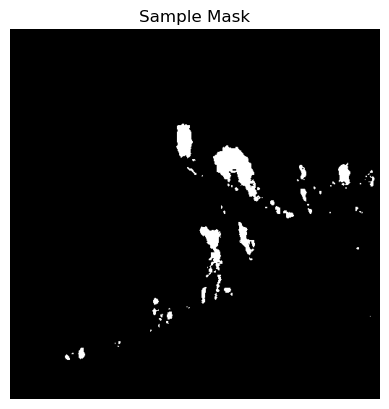

In [20]:
# Confirm if tiles[] holds masks
if len(masks_float64) > 0:
    # Display the number of masks loaded
    print(f"Number of masks loaded: {len(masks_float64)}")

    # Display a sample image
    sample_mask = masks_float64[1]

    print(f"Shape of sample mask: {sample_mask.shape}")

    # Plot the sample image as grayscale
    plt.imshow(sample_mask, cmap='gray')
    plt.title("Sample Mask")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded from the directory.")

- ### Print Mask Image matrix

In [21]:
masks_float64[1]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

## Split into Training and Validation sets

In [22]:
# Import library
from sklearn.model_selection import train_test_split

- ### confirm details and length of the Masks and tiles np arrays

In [23]:
print(f"The length of tiles_array is {len(tiles)}, the dtype is {normalized_tiles[0].dtype}, dimension is {normalized_tiles[0].shape}, image type: {type(normalized_tiles[0])}")
print(f"The length of masks_array is {len(masks_float64)}, the dtype is {masks_float64[0].dtype}, dimension is {masks_float64[0].shape}, image type: {type(masks_float64[0])}")

The length of tiles_array is 99, the dtype is float64, dimension is (512, 512, 3), image type: <class 'numpy.ndarray'>
The length of masks_array is 99, the dtype is float64, dimension is (512, 512, 1), image type: <class 'numpy.ndarray'>


In [24]:
# import user defined function to plot tiles and masks from functions/iplot_masks_tiles.py 
from plot_masks_tiles import plot_masks_vs_tiles

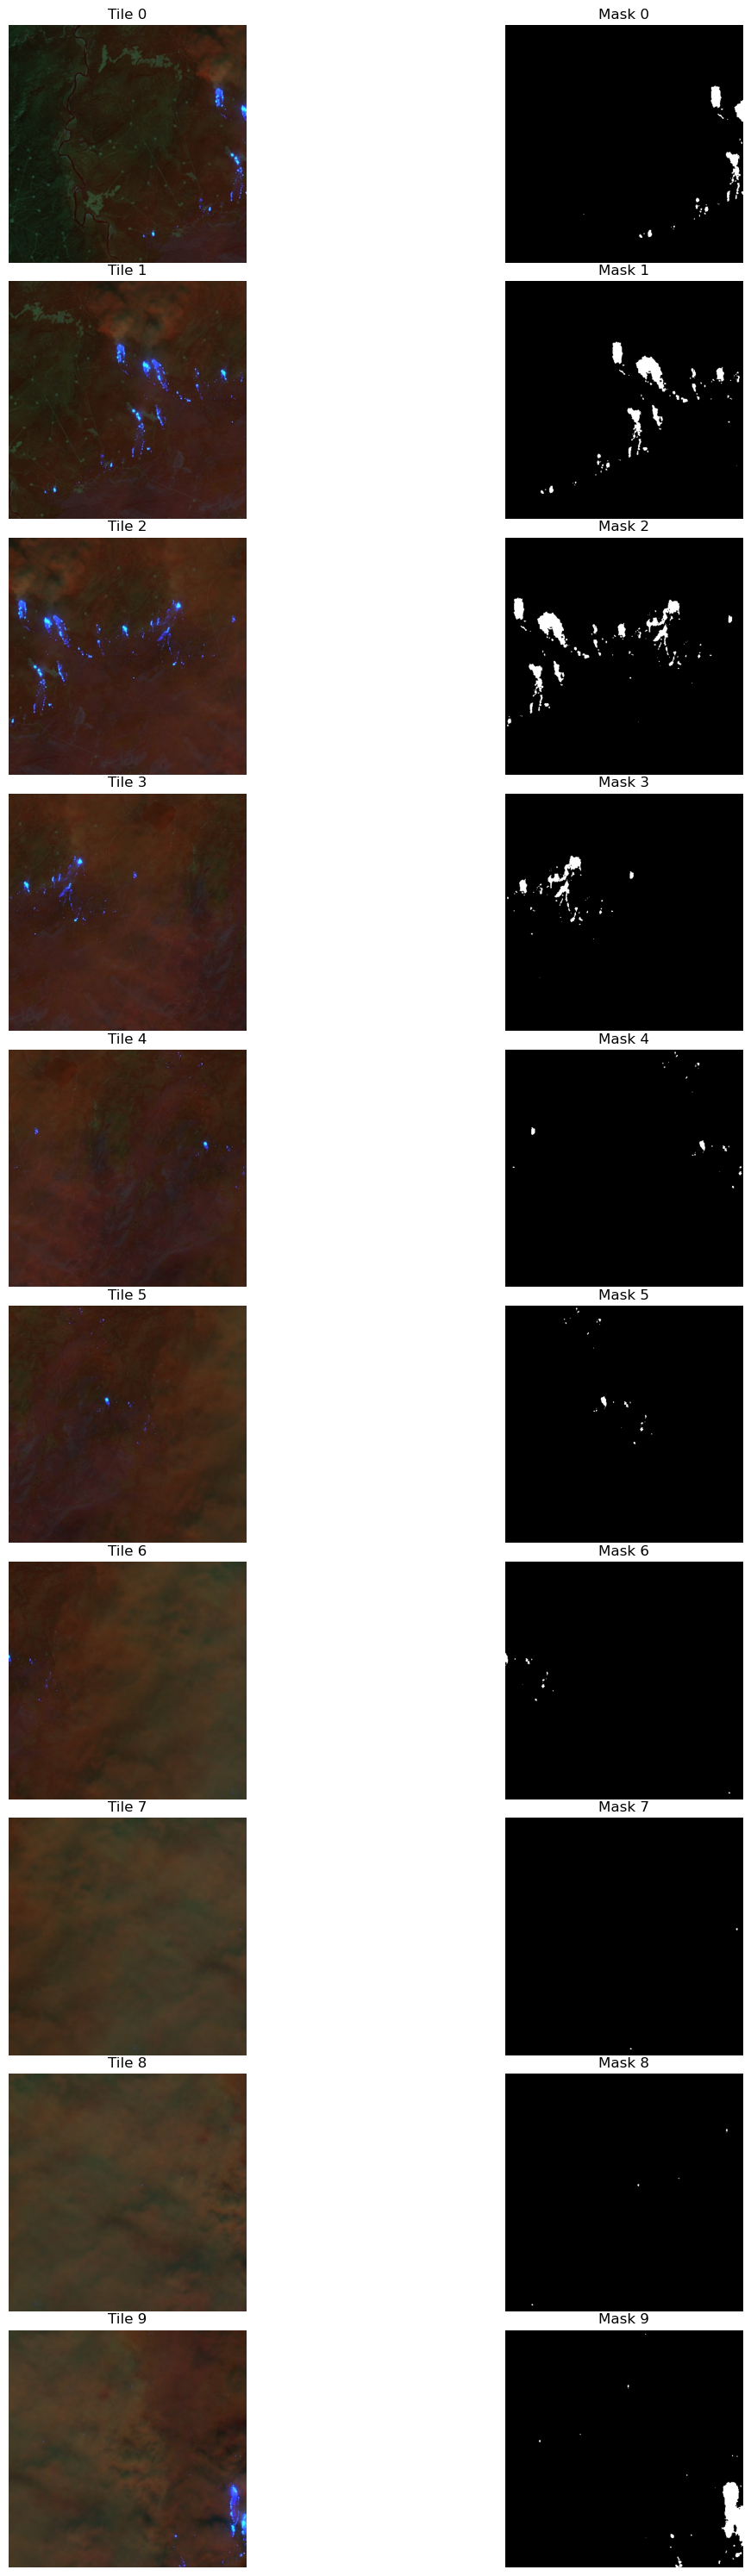

In [25]:
# Define the number of tiles to plot
num_tiles_to_plot = 10

# Plot the tiles and masks
fig, axs = plt.subplots(num_tiles_to_plot, 2, figsize=(15, 30))  # Adjust the figure size here

for i in range(num_tiles_to_plot):
    # Plot the tile (colored)
    tile_index = i  # Adjust this index based on how your tiles are loaded
    mask_index = i  # Adjust this index based on how your masks are loaded
    axs[i, 0].imshow(tiles[tile_index])
    axs[i, 0].set_title(f'Tile {tile_index}')
    axs[i, 0].axis('off')
    
    # Plot the mask (black and white)
    axs[i, 1].imshow(masks_float64[mask_index], cmap='gray')
    axs[i, 1].set_title(f'Mask {mask_index}')
    axs[i, 1].axis('off')

plt.tight_layout(h_pad=0.1)  # Adjust the spacing between subplots here
plt.show()



In [27]:
X_train, X_val, y_train, y_val = train_test_split(tiles, masks_float64, test_size=0.2, random_state=42)

In [34]:
# convert X_train, X_val to Np arrays
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)

In [36]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (79, 512, 512, 3)
X_val shape: (20, 512, 512, 3)
y_train shape: (79, 512, 512, 1)
y_val shape: (20, 512, 512, 1)


In [37]:
# check data types
print(f'Type of X_train {type(X_train)}')
print(f'Type of X_val {type(X_val)}')
print(f'Type of y_train {type(y_train)}')
print(f'Type of y_val {type(y_val)}')

Type of X_train <class 'numpy.ndarray'>
Type of X_val <class 'numpy.ndarray'>
Type of y_train <class 'numpy.ndarray'>
Type of y_val <class 'numpy.ndarray'>


#### Note:
<p> 
    - X_train and y_train contains the training data <br> 
    - X_val and y_val contains the validation data
</p>

## UNET Model design

- ### Setup Early  Earlystopping and Checkpoints

In [38]:
# Define directory to save the checkpoints
checkpoint_dir = '../checkpoints'

# directory check
os.makedirs(checkpoint_dir, exist_ok=True)

# checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'unet_checkpoint.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

- ### import cross entropy loss

In [39]:
from tensorflow.keras.losses import BinaryCrossentropy

# Create an instance of BinaryCrossentropy
bce_loss = BinaryCrossentropy()

- ### Import Unet script

In [40]:
# import unet model function from functions/unet.py
from unet import unet

### Build Model

In [41]:
unet_model = unet()

### Compile Model

In [42]:
# Compile the model with an appropriate loss function for multiclass segmentation
unet_model = unet()
unet_model.compile(optimizer='adam', loss=bce_loss, metrics=['accuracy'])

### Model Summary

In [43]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 512, 512, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 512, 512, 32)         9248      ['conv2d_15[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 256, 256, 32)         0         ['conv2d_16[0][0]']           
 g2D)                                                                                       

### Fit Model

In [ ]:
start_time = time.time()

unet_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1
)

stop_time = time.time() - start_time
print(f"Unet Model Training time is {stop_time} seconds")

Epoch 1/100
2/3 [===================>..........] - ETA: 2:51 - loss: -89.1058 - accuracy: 0.3643

### Training split 

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(tiles_array, masks_array, test_size=0.3)

### Run Model Evaluation

In [ ]:
score = unet_model.evaluate(test_data, test_labels, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Run  Model predictions

In [ ]:
predictions = unet_model.predict(test_data)

In [ ]:
'''
    View datatypes and information of Predictions  
'''
#test
print(test_preds.shape)  # Check the shape
print(test_preds.dtype)  # Check the data type

In [ ]:
#get first 10 images, view input and ouput images on every line
test_preds = unet_model.predict(test_data[0:8])